In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [94]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from typing import TypedDict , Annotated
from pydantic import BaseModel , Field
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from langgraph.graph import StateGraph , START , END


In [95]:
def display_graph(app):
    # this function will display the graph of the app
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print(e)

def stream_output(app, input):
    for output in app.stream(input):
        for key,value in output.items():
            print(f"here is output from {key}")
            print("_______")
            print(value)
            print("\n")

In [96]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [97]:
model.invoke("What is the capital of France?")

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--39cfef66-9e99-4ad7-88be-375cd2e660dc-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [98]:
#create a state class
class GraphState(TypedDict):
    messages : Annotated[list, add_messages]

In [ ]:
def call_llm(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


In [10]:
workflow = StateGraph(GraphState)
workflow.add_node("chatbot", call_llm)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

app = workflow.compile()


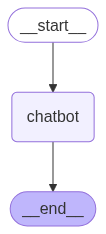

In [21]:
display_graph(app)

In [23]:
response = app.invoke({"messages": [HumanMessage(content="What is the capital of France?")]})

In [24]:
response

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}, id='685ab526-3af3-4bd2-b0f2-e4e07c1b5eca'),
  AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--61c5f529-33ab-48d2-b4c1-aeed6b82d969-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [28]:
input = {"messages": [HumanMessage(content="What is the capital of France?")]}

In [29]:
stream_output(app,input)

here is output from chatbot
_______
{'messages': [AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--68d8a258-71e9-4782-bb3f-a1b2a4b42b1e-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}




## Using tool

In [99]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode


In [100]:
@tool

def weather_search(query: str) -> str:
    """
    Search the web for weather query and return the weather
    """
    return "It is a sunny day"

In [101]:
weather_search.invoke("What is the weather in Tokyo?")

'It is a sunny day'

In [102]:
tools = [weather_search]

tool_node = ToolNode(tools)

In [103]:
llm_with_tool = model.bind_tools(tools)

In [104]:
def call_model(state: GraphState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [82]:
response = call_model({"messages":["what is the weather in Tokyo?"]})
print(response)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jmyvp4wjaYwIGzuyo3NeqcIg', 'function': {'arguments': '{"query":"Tokyo"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 55, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d9d6d21e-7cca-4c76-a9e2-c3732ff4dfae-0', tool_calls=[{'name': 'weather_search', 'args': {'query': 'Tokyo'}, 'id': 'call_jmyvp4wjaYwIGzuyo3NeqcIg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 55, 'output_tokens': 14, 'total_tokens': 69, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 're

In [83]:
last_message = response["messages"][-1]

In [84]:
last_message.tool_calls

[{'name': 'weather_search',
  'args': {'query': 'Tokyo'},
  'id': 'call_jmyvp4wjaYwIGzuyo3NeqcIg',
  'type': 'tool_call'}]

In [105]:
def router(state):

    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "tools"
    else:
        return END

In [ ]:
workflow = StateGraph(GraphState)
workflow.add_node("call_model", call_model)
workflow.add_node ("tools", tool_node)

workflow.add_edge(START, "call_model")
workflow.add_conditional_edges(
    "call_model",
    router,
    {
        "tools": "tools",
        END : END
    }
)

app = workflow.compile()


In [87]:
app.invoke({"messages":["what is the weather in Tokyo?"]})

{'messages': [HumanMessage(content='what is the weather in Tokyo?', additional_kwargs={}, response_metadata={}, id='070885a8-3366-490f-a742-501a62dd7a17'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VHVlsOGaMUx9TrR4tFgl4fhF', 'function': {'arguments': '{"query":"Tokyo"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 55, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--557699d8-72be-4144-9f4f-05228748c8cb-0', tool_calls=[{'name': 'weather_search', 'args': {'query': 'Tokyo'}, 'id': 'call_VHVlsOGaMUx9TrR4tFgl4fhF', 'type': 'tool_call'}], usage_metadata={'input_toke

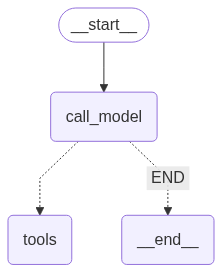

In [88]:
display(app)

In [106]:
workflow = StateGraph(GraphState)
workflow.add_node("agent", call_model)
workflow.add_node ("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    router,
    {
        "tools": "tools",
        END: END
    }
)

workflow.add_edge("tools", "agent")

app = workflow.compile()

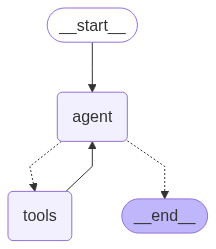

In [107]:
display(app)

In [108]:
app.invoke({"messages":["what is the weather in Tokyo?"]})

{'messages': [HumanMessage(content='what is the weather in Tokyo?', additional_kwargs={}, response_metadata={}, id='dc6e9a68-f371-4b1c-b6e5-7c16f9e24a87'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_x777p93mWYmaPBO7RnaSdOiP', 'function': {'arguments': '{"query":"Tokyo"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 55, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a142fbc7-ed8e-4b82-b174-d55310090efa-0', tool_calls=[{'name': 'weather_search', 'args': {'query': 'Tokyo'}, 'id': 'call_x777p93mWYmaPBO7RnaSdOiP', 'type': 'tool_call'}], usage_metadata={'input_toke

## memory in agents

In [110]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [111]:
react_graph_memory = workflow.compile(checkpointer=memory)

In [112]:
config = {"configurable": {"thread_id": "1"}}

In [114]:
# Specify an input
input_message = [HumanMessage(content="what is the weather in Tokyo?")]

In [117]:
react_graph_memory.invoke({"messages": input_message}, config)

{'messages': [HumanMessage(content='what is the weather in Tokyo?', additional_kwargs={}, response_metadata={}, id='bc93a10b-ad44-4ac3-b3d0-95be3d58b684'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FTP0l1oVhovMufvjCMznPpcA', 'function': {'arguments': '{"query":"Tokyo"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 55, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1654449a-b24c-4cde-9635-6b49d053deb4-0', tool_calls=[{'name': 'weather_search', 'args': {'query': 'Tokyo'}, 'id': 'call_FTP0l1oVhovMufvjCMznPpcA', 'type': 'tool_call'}], usage_metadata={'input_toke